In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter
from itertools import chain, combinations
import sklearn as sk
from sklearn.decomposition import PCA

# Data exploration

In this notebook we plot a heatmap of correlations between our variables.  
We also apply PCA to our data andclusering algorithms, namely:
+ K-Means
+ GMM  

Then we plot histograms of the distributions of values in all of our variables.

In [2]:
data = pd.read_csv("newdata3.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
#data.info()
#no duplicates
#data = data.drop_duplicates(subset = ['weight_16', 'height_16'])
#data.info()

<AxesSubplot:>

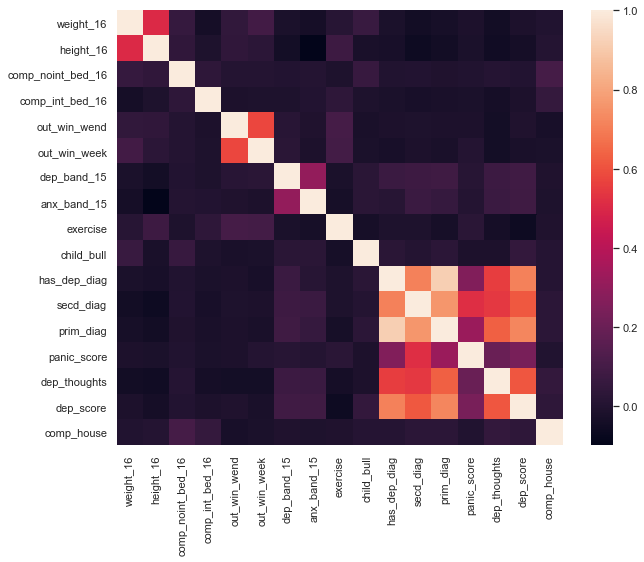

In [4]:
sns.set(rc = {'figure.figsize':(10, 8)})
sns.heatmap(data.corr())

<AxesSubplot:xlabel='level_0', ylabel='level_1'>

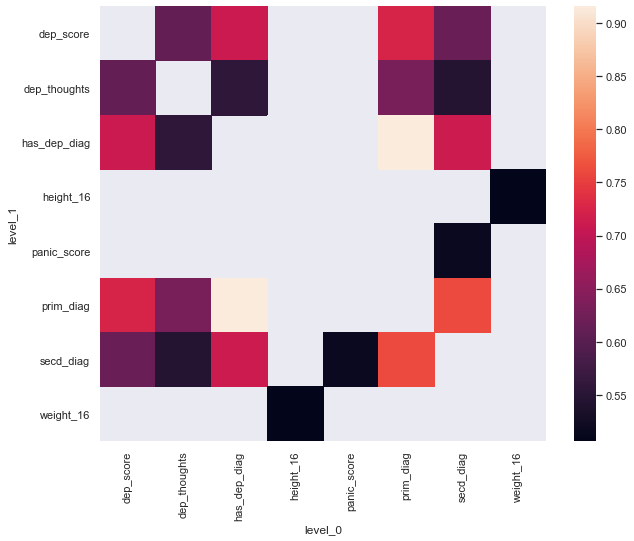

In [5]:
#getting rid of obvious correlations

s = data.corr().abs().unstack()
high = s.sort_values()

for i in high.index:
    split1 = i[0].rstrip('we k nd')
    split2 = i[1].rstrip('we k nd')
    split1 = split1.rstrip('_')
    split2 = split2.rstrip('_')
    if split1 == i[1] or split2 == i[0] or split1 == split2:
        high[i[0], i[1]] = 2
        
high = high[high >= 0.5]
high = high[high < 1]
high = high.to_frame().reset_index()
corr = pd.pivot_table(high, columns = ['level_0'], values = 0, index = ['level_1'])
sns.heatmap(corr)

<AxesSubplot:>

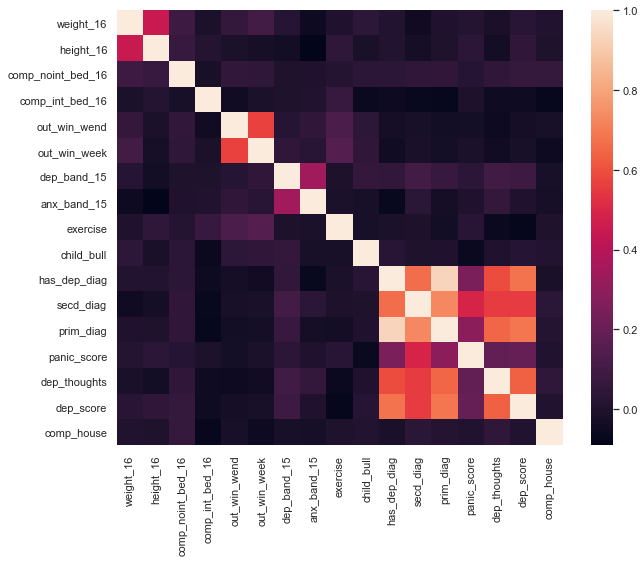

In [6]:
#target variables
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]

#keeping rows with no missing data
full = data.dropna(axis = 0, how = 'any')
sns.heatmap(full.corr())

## Logistic Regression and PCA

In [7]:
#attempt at mitigating imbalanced data
lim = 8
no_dep = full.query('prim_diag in [4,10, 11, 12]')
has_dep = full.query('prim_diag not in [4,10, 11, 12]')

sample = no_dep.sample(n = 150, random_state = 1)
sample2 = has_dep.sample(n = 150, random_state = 1)

fullSample = sample.append(sample2)

In [16]:
#input variables
X = fullSample.drop(dep[1:-1], axis = 1)

In [9]:
#using logistic regression on X and X_pca
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

pca = PCA(0.9)

#error for dep_band_15 since its continous so i dropped it
for i in dep[1:-1]:
    y = fullSample[i]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size = 0.2, random_state = 30)

    model = LogisticRegression(max_iter = 10000)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    X_pca = pca.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 30)
    
    model2 = LogisticRegression(max_iter = 10000)
    model2.fit(X_train, y_train)
    score2 = model2.score(X_test, y_test)
    print(i, score, score2)

has_dep_diag 0.75 0.5166666666666667
secd_diag 0.55 0.5
prim_diag 0.4166666666666667 0.3333333333333333
panic_score 0.8833333333333333 0.8833333333333333
dep_thoughts 0.4166666666666667 0.26666666666666666


In [10]:
pca.explained_variance_ratio_

array([0.47642073, 0.30119165, 0.11206744, 0.09919598])

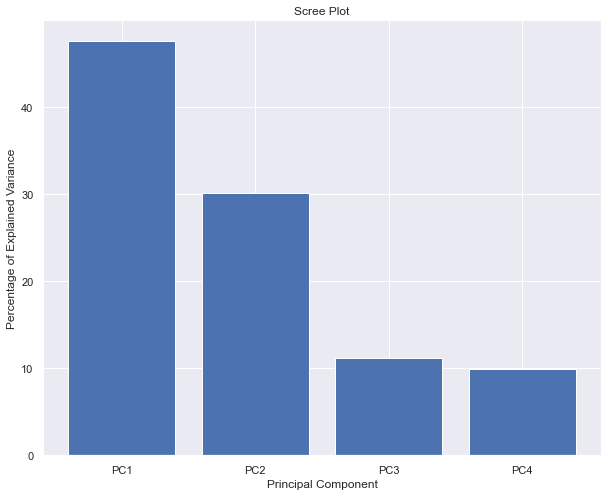

In [12]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

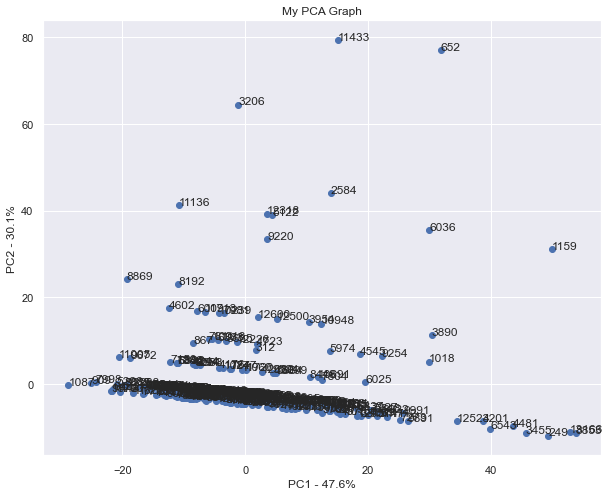

In [13]:
#??
pca_df = pd.DataFrame(X_pca, index = X.index, columns = labels)
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1])) 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

In [14]:
#more pca
pca2 = PCA(n_components=2)
pca2.fit_transform(X)
print(pca2.explained_variance_ratio_)

[0.47642073 0.30119165]


original shape:    (300, 12)
transformed shape: (300, 2)


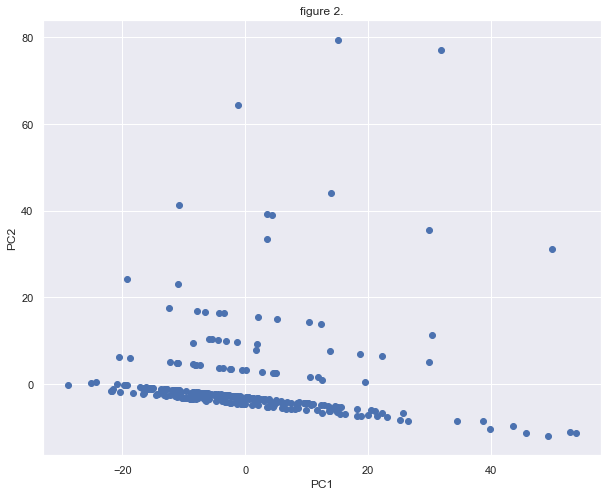

In [15]:
X_pca = pca2.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=1)
#for sample in pca2.index:
 #   plt.annotate(sample, (pca2.PC1.loc[sample], pca2.PC2.loc[sample]))
plt.title("figure 2.")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('auto');


## ICA

In [23]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3)
X_ica = ica.fit_transform(X)
ica.components_
ica.n_features_in_
ReducedData=pd.DataFrame(data=X_ica)
print(ReducedData.head(10))

          0         1         2
0  0.011681 -0.025694 -0.038062
1 -0.039249 -0.023592 -0.043532
2  0.002966 -0.023536 -0.026621
3  0.023623 -0.018192 -0.004453
4 -0.021962  0.240994  0.000823
5 -0.186410  0.049869 -0.039140
6  0.033182 -0.015032  0.061020
7 -0.016551  0.048679 -0.045391
8 -0.071729 -0.025880 -0.076426
9 -0.037429 -0.016243 -0.019365


## K-Means

In [21]:
from sklearn.cluster import KMeans

In [22]:
def plot_k_means(X, cluster_assignments, centroid_locations):
    plt.axis('auto')
    plt.viridis()
    plt.scatter(X[:, 0], X[:, 1], s=20, c=cluster_assignments, alpha=0.9)
    plt.scatter(centroid_locations[:, 0], centroid_locations[:, 1], s=200, marker='X', c=range(K), edgecolors='k')
    plt.title("figure 3.")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()



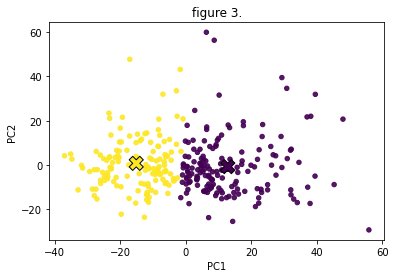

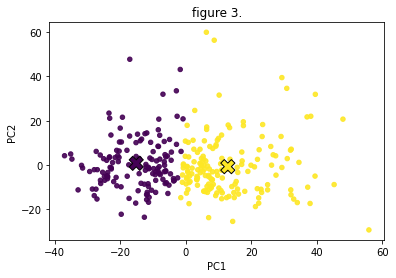

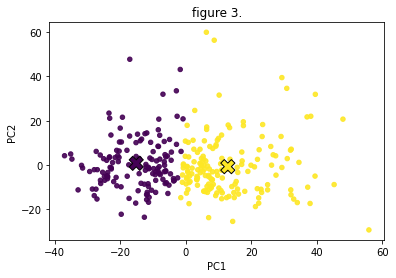

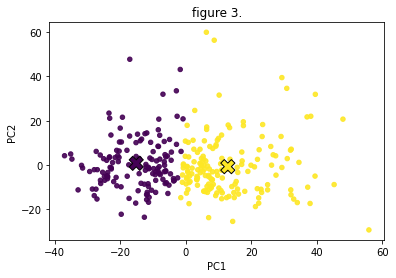

In [23]:
K = 2
kmeans = KMeans(K, init='random').fit(X_pca)
cluster_assignments = kmeans.predict(X_pca)
centroid_locations = kmeans.cluster_centers_
plot_k_means(X_pca, cluster_assignments, centroid_locations)

kmeans1 = KMeans(K).fit(X_pca)
cluster_assignments1 = kmeans1.predict(X_pca)
centroid_locations1 = kmeans1.cluster_centers_
plot_k_means(X_pca, cluster_assignments1, centroid_locations1)

kmeans2 = KMeans(K, init='random', max_iter = 2000).fit(X_pca)
cluster_assignments2 = kmeans2.predict(X_pca)
centroid_locations2 = kmeans2.cluster_centers_
plot_k_means(X_pca, cluster_assignments2, centroid_locations2)

kmeans3 = KMeans(K, init='random', n_init = 200).fit(X_pca)
cluster_assignments3 = kmeans3.predict(X_pca)
centroid_locations3 = kmeans3.cluster_centers_
plot_k_means(X_pca, cluster_assignments3, centroid_locations2)

## Gaussian Mixture Model

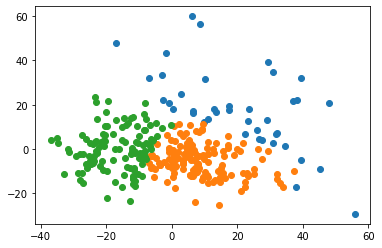

In [24]:
# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

X = X_pca
model = GaussianMixture(n_components=3)
model.fit(X)
yhat = model.predict(X)
clusters = unique(yhat)
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

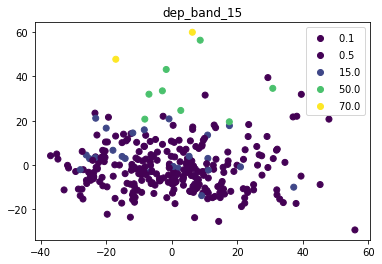

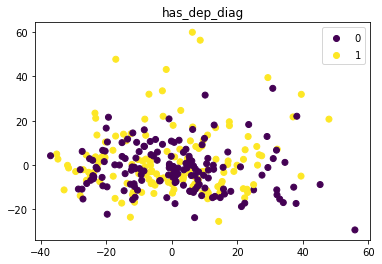

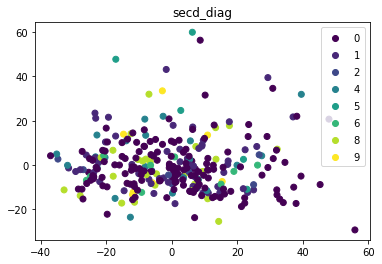

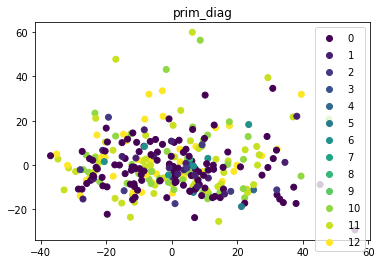

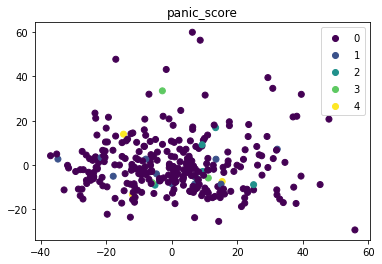

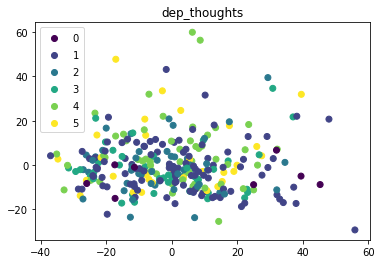

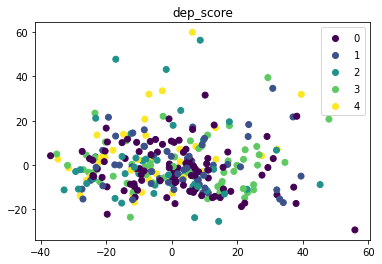

In [25]:
#comparing to data split on target variables

for i in dep:
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=1, c = fullSample[i], cmap = 'viridis')
    plt.legend(*scatter.legend_elements())
    plt.title(i)
    plt.show()

array([[<AxesSubplot:title={'center':'weight_16'}>,
        <AxesSubplot:title={'center':'height_16'}>,
        <AxesSubplot:title={'center':'iq'}>,
        <AxesSubplot:title={'center':'dep_band_15'}>,
        <AxesSubplot:title={'center':'anx_band_15'}>],
       [<AxesSubplot:title={'center':'exercise'}>,
        <AxesSubplot:title={'center':'child_bull'}>,
        <AxesSubplot:title={'center':'has_dep_diag'}>,
        <AxesSubplot:title={'center':'secd_diag'}>,
        <AxesSubplot:title={'center':'prim_diag'}>],
       [<AxesSubplot:title={'center':'panic_score'}>,
        <AxesSubplot:title={'center':'dep_thoughts'}>,
        <AxesSubplot:title={'center':'dep_score'}>,
        <AxesSubplot:title={'center':'comp_house'}>,
        <AxesSubplot:title={'center':'alon'}>],
       [<AxesSubplot:title={'center':'draw'}>,
        <AxesSubplot:title={'center':'musi'}>,
        <AxesSubplot:title={'center':'out_sum'}>,
        <AxesSubplot:title={'center':'out_win'}>,
        <AxesSubplot:t

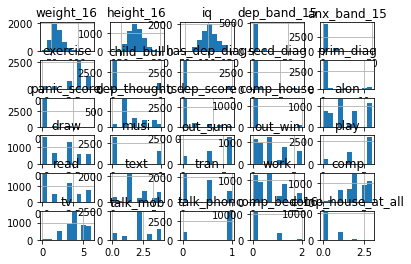

In [26]:
data.hist()

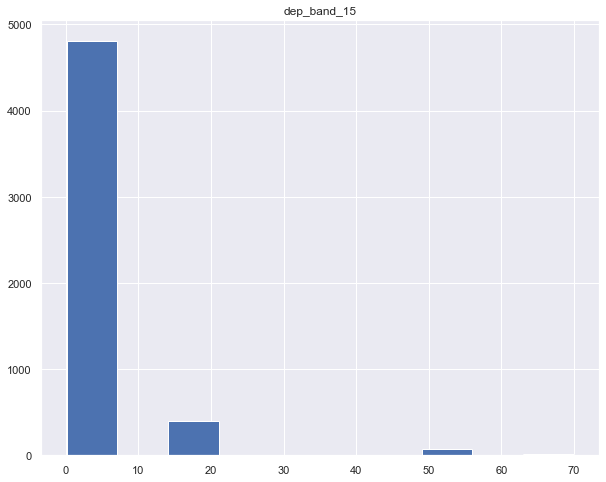

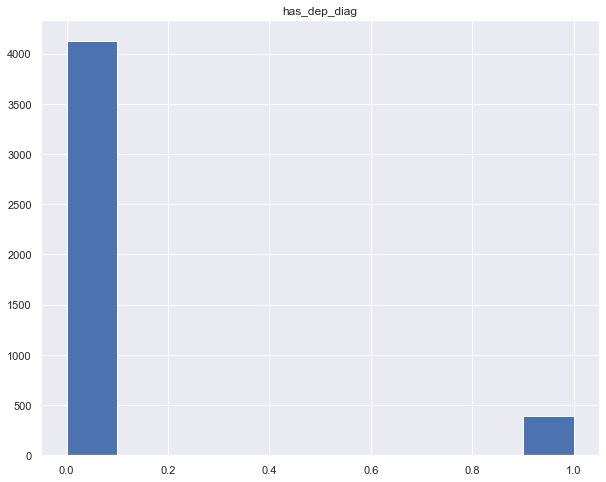

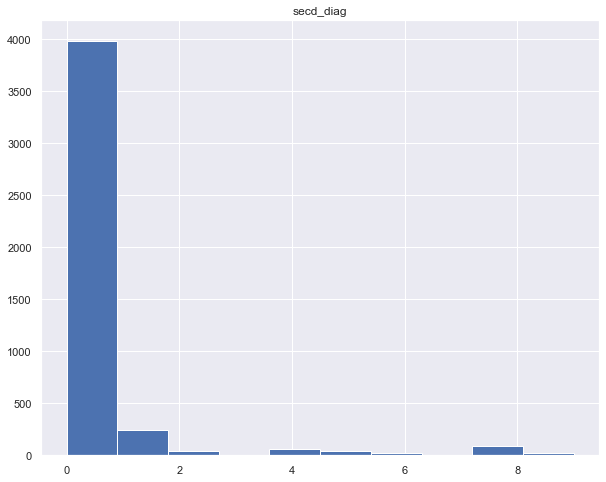

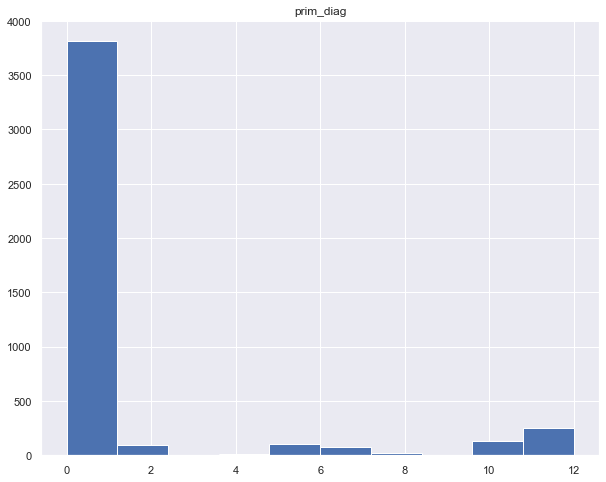

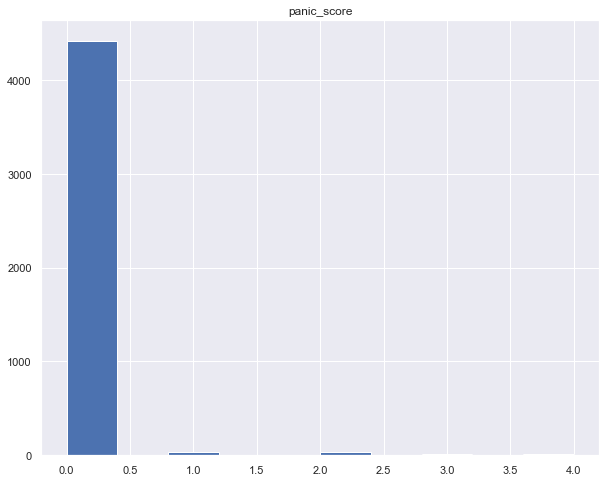

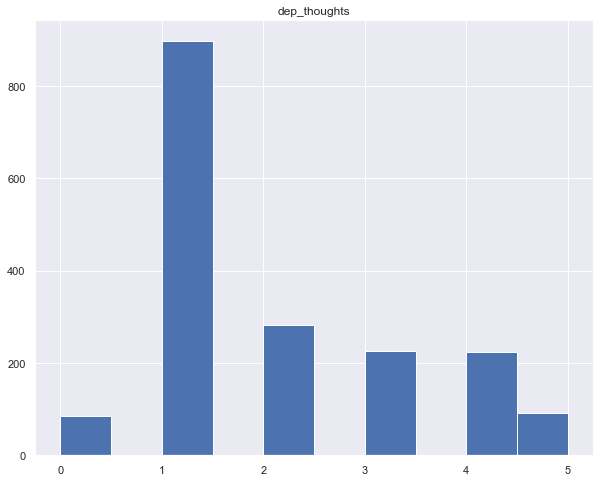

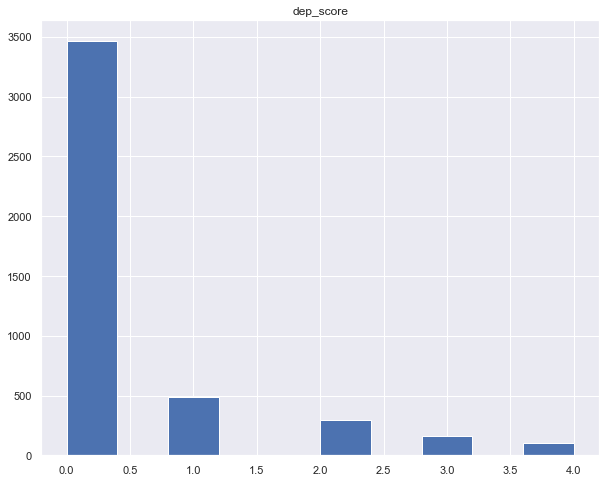

In [22]:
for i in dep:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.hist(data[i])
    plt.title(i)